In [1]:
import simtool as st

c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



### Initialisation du problème

In [2]:
a1 , a2 , e , K , a = 0.088 , 0.020 , 0.96, 0.034, 0.086
params = [a1, a2, e, K, a]
param_names = ["a1", "a2", "e", "K", "a"]
t_max = 500 #days
x0, y0 = 0.12, 0.91
state_0 = [x0, y0]
data = st.data_gen(params, t_max, state_0, func_rep = 'holling1')
nbpoint = 20
noise_intensity = 0.03
noise_seed = 123

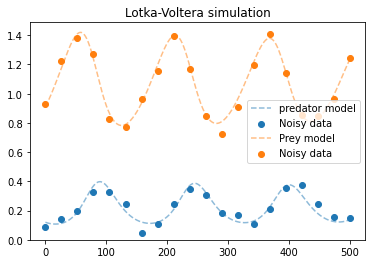

In [3]:
data.get_data(nbpoint=nbpoint, noise_intensity=noise_intensity, plot_data=True,noise_seed = noise_seed)

### Architecture 1

In [4]:
model = st.pinn(data)
model.get_train_data()
bc_weights = [5,5]
data_weights = [0.2,0.2] #car données tres bruitées
pde_weights = [10,10] #car données tres bruitées
poids_p1 = [0] * 2 + bc_weights + data_weights
poids_p2 = pde_weights + bc_weights + data_weights
poids = [poids_p1,poids_p2]
pfv_1 = 'train_architecture_1.dat'
lr = 1e-5

In [7]:
import deepxde as dde

print(model.x)
print(model.y)
y1, y2 = model.y[:,0:1], model.y[:,1:2]
print("y1 : ", y1)
print("y2 : ", y2)
dy1_x = dde.grad.jacobian(model.y, model.x, i=0)
dy2_x = dde.grad.jacobian(model.y, model.x, i=1)
print("dy1_x : ", dy1_x)
print("dy2_x : ", dy2_x)

frep_predateur = model.func_rep_dict[model.data.func_rep](y2)
dy1_x_model = - model.a1_estim*y1 + model.e_estim*y1*frep_predateur
dy2_x_model = model.a2_estim*y2*(1-model.K_estim*y2) - y1*frep_predateur
print("dy1_x_model : ", dy1_x_model)
print("dy2_x_model : ", dy2_x_model)

dy1_x - dy1_x_model
dy2_x - dy2_x_model
    

Tensor("Placeholder_2:0", shape=(None, 1), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(None, 2), dtype=float32)
y1 :  Tensor("strided_slice_20:0", shape=(None, 1), dtype=float32)
y2 :  Tensor("strided_slice_21:0", shape=(None, 1), dtype=float32)
dy1_x :  Tensor("gradients/dense/MatMul_grad/MatMul:0", shape=(None, 1), dtype=float32)
dy2_x :  Tensor("gradients_1/dense/MatMul_grad/MatMul:0", shape=(None, 1), dtype=float32)
dy1_x_model :  Tensor("add_4:0", shape=(None, 1), dtype=float32)
dy2_x_model :  Tensor("sub_27:0", shape=(None, 1), dtype=float32)


<tf.Tensor 'sub_29:0' shape=(None, 1) dtype=float32>

In [5]:
model.compile_model(lr=lr,nnlayers = [1] + [128] * 3 + [2],activation_function="swish",initcond = "Glorot normal",poids = poids,path_file_var = pfv_1,niter_p1=1000,niter_p2=500000)

Partie 1 de l'entrainement
Compiling model...
Building feed-forward neural network...


c:\Users\Raph\AppData\Local\Programs\Python\Python310\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.369594 s



'compile' took 7.227202 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 1.23e+01, 2.71e+02]    [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 1.23e+01, 2.71e+02]    []  


KeyboardInterrupt: 

In [6]:
model.recap_train()

L'entrainement a pris 18 minutes et 23 secondes


In [7]:
sp_model = st.model_scipy(data)

In [8]:
dp = st.displayer(model)

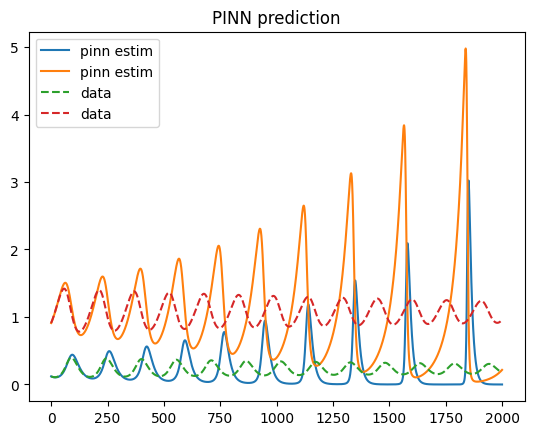

In [9]:
dp.plot_tlong(sp_model)

Evolution de la valeur des paramètres au cours de l'entrainement


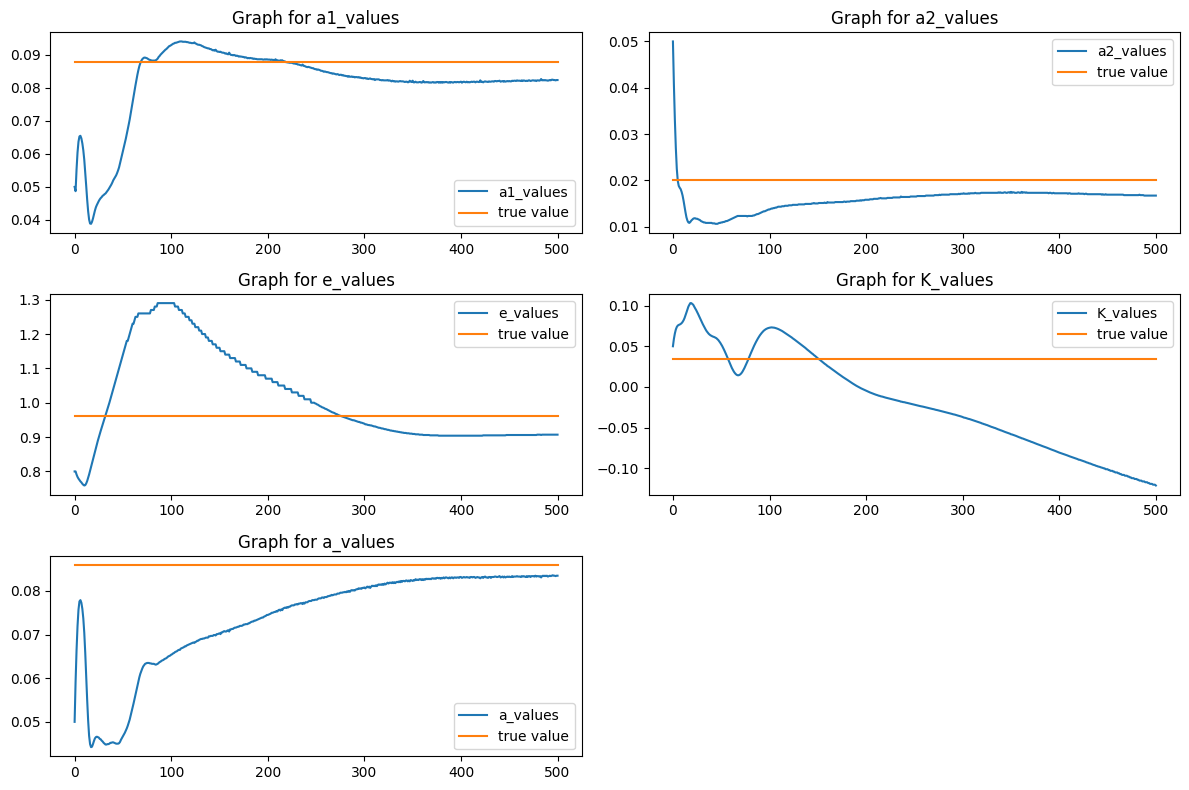

In [10]:
dp.plot_convergence()

### Architecture 2

In [11]:
model_2 = st.pinn(data)
model_2.get_train_data()
bc_weights = [5,5]
data_weights = [0.1,0.1] #car données tres bruitées
pde_weights = [10,10] #car données tres bruitées
pfv_2 = 'train_architecture_2.dat'

In [12]:
model_2.compile_model(lr=lr,nnlayers = [1] + [64] * 5 + [2],activation_function="swish",initcond = "Glorot normal",poids = poids,path_file_var = pfv_2,niter_p1=1000,niter_p2=500000)

Partie 1 de l'entrainement
Compiling model...
Building feed-forward neural network...
'build' took 0.065635 s

'compile' took 0.360181 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 4.25e+00, 1.55e+00]    [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 4.25e+00, 1.55e+00]    []  
1000      [0.00e+00, 0.00e+00, 6.23e-02, 2.81e+00, 2.11e-03, 2.98e-02]    [0.00e+00, 0.00e+00, 6.23e-02, 2.81e+00, 2.11e-03, 2.98e-02]    []  

Best model at step 1000:
  train loss: 2.90e+00
  test loss: 2.90e+00
  test metric: []

'train' took 3.549545 s

Partie 2 de l'entrainement
Compiling model...
'compile' took 0.255592 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
1000      [7.02e-02, 6.62e-01, 6.23e-02, 2.81e+00,

2024-02-07 22:34:18.131576: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_9/bias/Adam_3/Assign' id:6943 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Adam_3/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@dense_9/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_9/bias/Adam_3, dense_9/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2000      [5.79e-04, 4.10e-03, 2.77e-02, 6.68e-01, 3.36e-03, 1.70e-02]    [5.79e-04, 4.10e-03, 2.77e-02, 6.68e-01, 3.36e-03, 1.70e-02]    []  
3000      [2.01e-04, 3.20e-03, 1.73e-04, 3.74e-04, 2.79e-03, 6.91e-03]    [2.01e-04, 3.20e-03, 1.73e-04, 3.74e-04, 2.79e-03, 6.91e-03]    []  
4000      [1.15e-04, 1.80e-03, 3.88e-07, 2.61e-07, 2.40e-03, 5.09e-03]    [1.15e-04, 1.80e-03, 3.88e-07, 2.61e-07, 2.40e-03, 5.09e-03]    []  
5000      [6.46e-05, 8.96e-04, 9.68e-08, 2.14e-08, 2.05e-03, 4.60e-03]    [6.46e-05, 8.96e-04, 9.68e-08, 2.14e-08, 2.05e-03, 4.60e-03]    []  
6000      [3.68e-05, 4.16e-04, 1.56e-08, 8.26e-09, 1.83e-03, 4.50e-03]    [3.68e-05, 4.16e-04, 1.56e-08, 8.26e-09, 1.83e-03, 4.50e-03]    []  
7000      [2.36e-05, 2.04e-04, 1.21e-11, 4.20e-09, 1.69e-03, 4.41e-03]    [2.36e-05, 2.04e-04, 1.21e-11, 4.20e-09, 1.69e-03, 4.41e-03]    []  
8000      [1.86e-05, 1.41e-04, 3.23e-09, 3.00e-09, 1.62e-03, 4.33e-03]    [1.86e-05, 1.41e-04, 3.23e-09, 3.00e-09, 1.62e-03, 4.33e-03]    []  

In [13]:
model_2.recap_train()

L'entrainement a pris 31 minutes et 11 secondes


In [14]:
dp_2 = st.displayer(model_2)

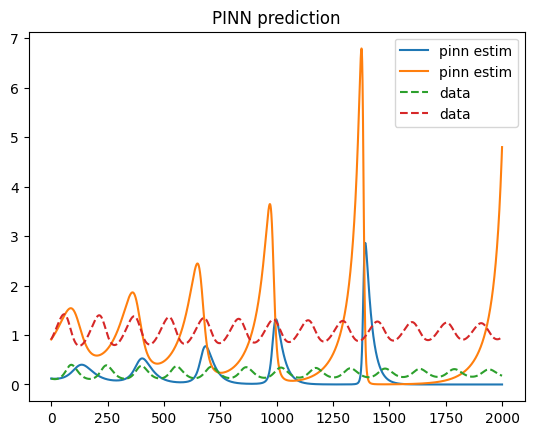

In [15]:
dp_2.plot_tlong(sp_model)

Evolution de la valeur des paramètres au cours de l'entrainement


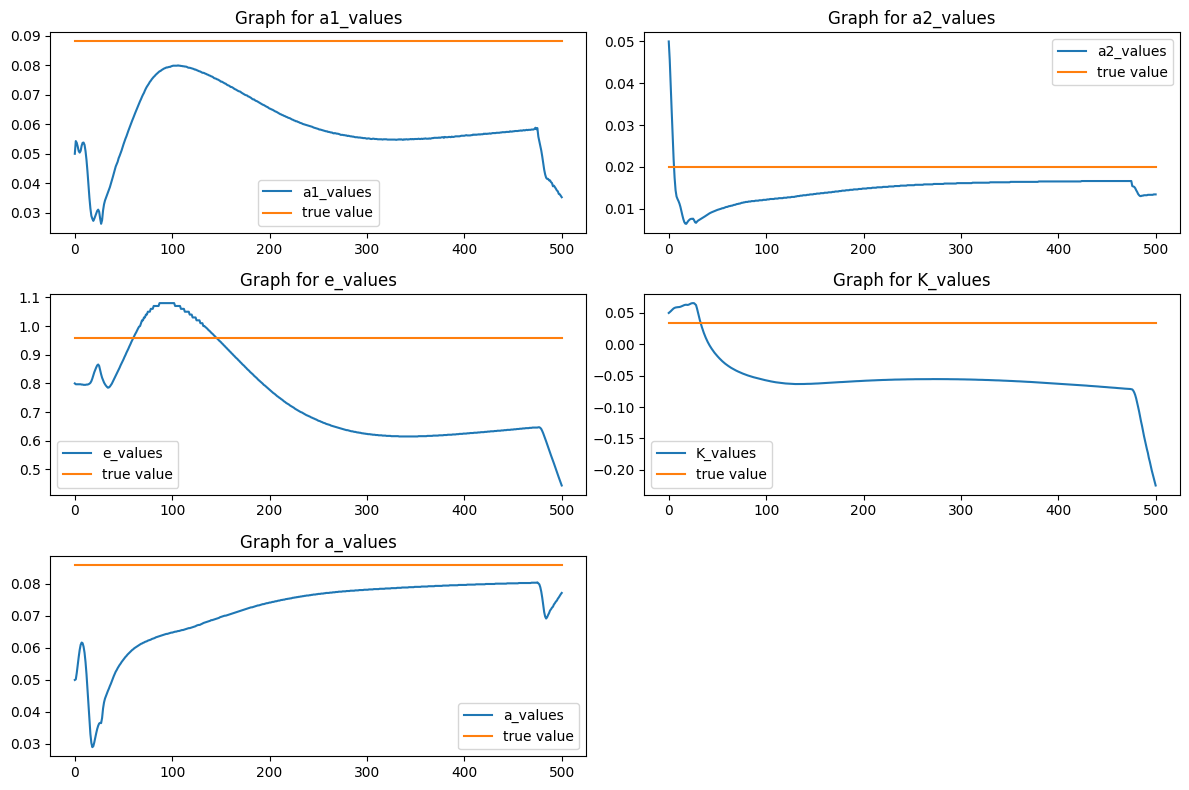

In [16]:
dp_2.plot_convergence()

### Architecture 3

In [17]:
model_3 = st.pinn(data)
model_3.get_train_data()
bc_weights = [5,5]
data_weights = [0.1,0.1] #car données tres bruitées
pde_weights = [10,10] #car données tres bruitées
pfv_3 = 'train_architecture_3.dat'

In [18]:
model_3.compile_model(lr=lr,nnlayers = [1] + [40] * 2 + [2],activation_function="tanh",initcond = "Glorot normal",poids = poids,path_file_var = pfv_3,niter_p1=1000,niter_p2=500000)

Partie 1 de l'entrainement
Compiling model...
Building feed-forward neural network...
'build' took 0.022553 s

'compile' took 0.198726 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 3.17e-02, 2.71e-01]    [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 3.17e-02, 2.71e-01]    []  
1000      [0.00e+00, 0.00e+00, 5.19e-02, 2.80e+00, 3.84e-03, 8.77e-03]    [0.00e+00, 0.00e+00, 5.19e-02, 2.80e+00, 3.84e-03, 8.77e-03]    []  

Best model at step 1000:
  train loss: 2.86e+00
  test loss: 2.86e+00
  test metric: []

'train' took 0.742232 s

Partie 2 de l'entrainement
Compiling model...
'compile' took 0.118568 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
1000      [1.46e-04, 1.77e-02, 5.19e-02, 2.80e+00,

2024-02-07 23:05:27.040156: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_12/bias/Adam_3/Assign' id:8990 op device:{requested: '', assigned: ''} def:{{{node dense_12/bias/Adam_3/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@dense_12/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_12/bias/Adam_3, dense_12/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2000      [8.77e-05, 1.19e-02, 1.59e-02, 1.27e+00, 3.63e-03, 7.46e-03]    [8.77e-05, 1.19e-02, 1.59e-02, 1.27e+00, 3.63e-03, 7.46e-03]    []  
3000      [5.31e-05, 7.73e-03, 1.10e-03, 2.49e-01, 3.14e-03, 8.06e-03]    [5.31e-05, 7.73e-03, 1.10e-03, 2.49e-01, 3.14e-03, 8.06e-03]    []  
4000      [8.28e-05, 3.39e-03, 1.42e-05, 9.52e-03, 2.87e-03, 7.66e-03]    [8.28e-05, 3.39e-03, 1.42e-05, 9.52e-03, 2.87e-03, 7.66e-03]    []  
5000      [9.69e-05, 9.41e-04, 1.18e-07, 3.05e-05, 2.65e-03, 7.07e-03]    [9.69e-05, 9.41e-04, 1.18e-07, 3.05e-05, 2.65e-03, 7.07e-03]    []  
6000      [5.85e-05, 2.23e-04, 5.41e-08, 6.14e-09, 2.54e-03, 6.86e-03]    [5.85e-05, 2.23e-04, 5.41e-08, 6.14e-09, 2.54e-03, 6.86e-03]    []  
7000      [4.49e-05, 1.14e-04, 3.30e-08, 4.32e-08, 2.48e-03, 6.80e-03]    [4.49e-05, 1.14e-04, 3.30e-08, 4.32e-08, 2.48e-03, 6.80e-03]    []  
8000      [3.43e-05, 9.81e-05, 1.83e-08, 3.03e-08, 2.43e-03, 6.77e-03]    [3.43e-05, 9.81e-05, 1.83e-08, 3.03e-08, 2.43e-03, 6.77e-03]    []  

In [19]:
model_3.recap_train()

L'entrainement a pris 3 minutes et 30 secondes


In [20]:
dp_3 = st.displayer(model_3)

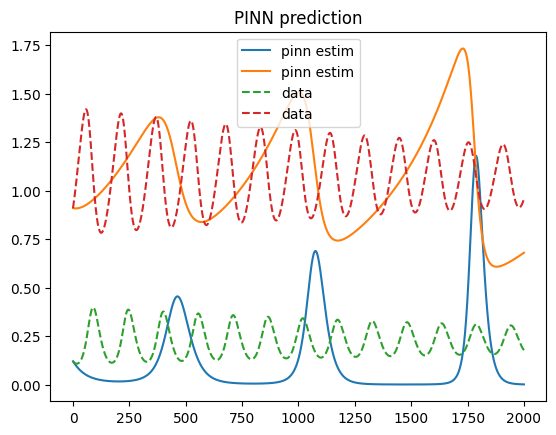

In [21]:
dp_3.plot_tlong(sp_model)

Evolution de la valeur des paramètres au cours de l'entrainement


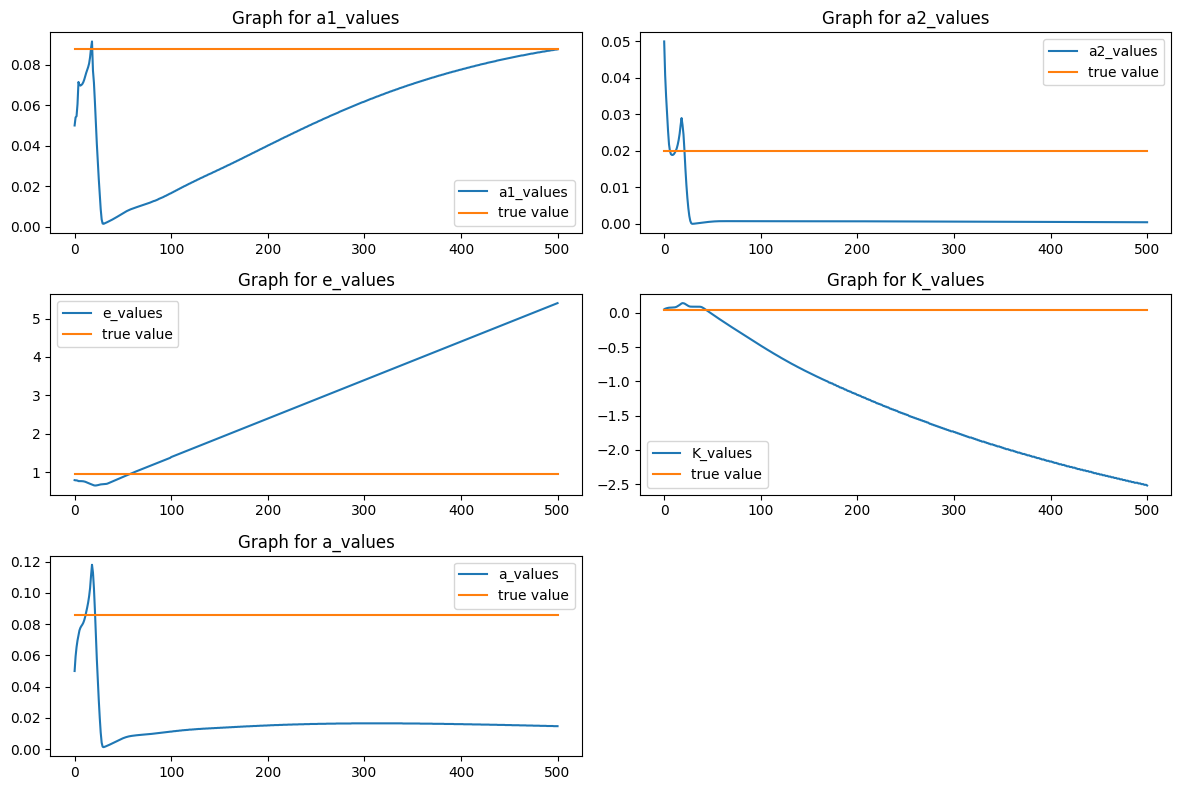

In [22]:
dp_3.plot_convergence()

### Architecture 4

In [23]:
model_4 = st.pinn(data)
model_4.get_train_data()
bc_weights = [5,5]
data_weights = [0.1,0.1] #car données tres bruitées
pde_weights = [10,10] #car données tres bruitées
pfv_4 = 'train_architecture_4.dat'

In [24]:
model_4.compile_model(lr=lr,nnlayers = [1] + [128] * 3 + [2],activation_function="tanh",initcond = "Glorot normal",poids = poids,path_file_var = pfv_4,niter_p1=1000,niter_p2=500000)

Partie 1 de l'entrainement
Compiling model...
Building feed-forward neural network...
'build' took 0.021404 s

'compile' took 0.217133 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 2.06e-01, 6.98e-01]    [0.00e+00, 0.00e+00, 7.20e-02, 4.14e+00, 2.06e-01, 6.98e-01]    []  
1000      [0.00e+00, 0.00e+00, 4.13e-03, 1.71e-01, 2.40e-03, 9.61e-03]    [0.00e+00, 0.00e+00, 4.13e-03, 1.71e-01, 2.40e-03, 9.61e-03]    []  

Best model at step 1000:
  train loss: 1.88e-01
  test loss: 1.88e-01
  test metric: []

'train' took 2.788269 s

Partie 2 de l'entrainement
Compiling model...
'compile' took 0.135332 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
1000      [5.10e-04, 1.98e-02, 4.13e-03, 1.71e-01,

2024-02-07 23:09:00.542745: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_16/bias/Adam_3/Assign' id:11297 op device:{requested: '', assigned: ''} def:{{{node dense_16/bias/Adam_3/Assign}} = Assign[T=DT_FLOAT, _class=["loc:@dense_16/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_16/bias/Adam_3, dense_16/bias/Adam_3/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


2000      [1.70e-05, 2.84e-03, 9.30e-10, 7.61e-10, 3.33e-03, 7.13e-03]    [1.70e-05, 2.84e-03, 9.30e-10, 7.61e-10, 3.33e-03, 7.13e-03]    []  
3000      [7.54e-06, 1.40e-03, 9.26e-10, 2.91e-08, 2.83e-03, 6.37e-03]    [7.54e-06, 1.40e-03, 9.26e-10, 2.91e-08, 2.83e-03, 6.37e-03]    []  
4000      [1.12e-05, 6.33e-04, 3.57e-10, 3.74e-08, 2.49e-03, 5.65e-03]    [1.12e-05, 6.33e-04, 3.57e-10, 3.74e-08, 2.49e-03, 5.65e-03]    []  
5000      [1.55e-05, 3.18e-04, 3.19e-11, 2.92e-08, 2.28e-03, 5.10e-03]    [1.55e-05, 3.18e-04, 3.19e-11, 2.92e-08, 2.28e-03, 5.10e-03]    []  
6000      [1.42e-05, 1.96e-04, 8.77e-10, 1.75e-08, 2.16e-03, 4.81e-03]    [1.42e-05, 1.96e-04, 8.77e-10, 1.75e-08, 2.16e-03, 4.81e-03]    []  
7000      [1.41e-05, 1.56e-04, 1.99e-09, 9.60e-09, 2.06e-03, 4.63e-03]    [1.41e-05, 1.56e-04, 1.99e-09, 9.60e-09, 2.06e-03, 4.63e-03]    []  
8000      [1.50e-05, 1.49e-04, 2.39e-09, 5.71e-09, 2.00e-03, 4.53e-03]    [1.50e-05, 1.49e-04, 2.39e-09, 5.71e-09, 2.00e-03, 4.53e-03]    []  

In [25]:
model_4.recap_train()

L'entrainement a pris 22 minutes et 32 secondes


In [26]:
dp_4 = st.displayer(model_4)

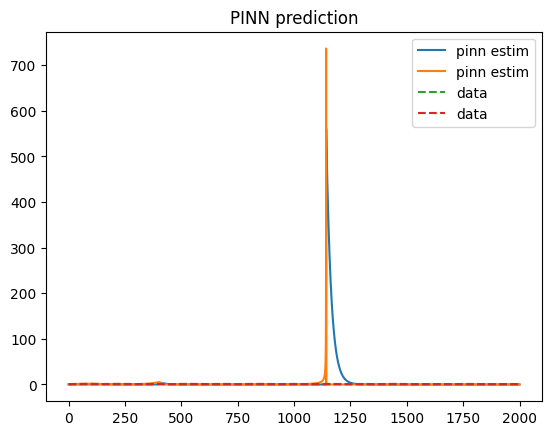

In [27]:
dp_4.plot_tlong(sp_model)

Evolution de la valeur des paramètres au cours de l'entrainement


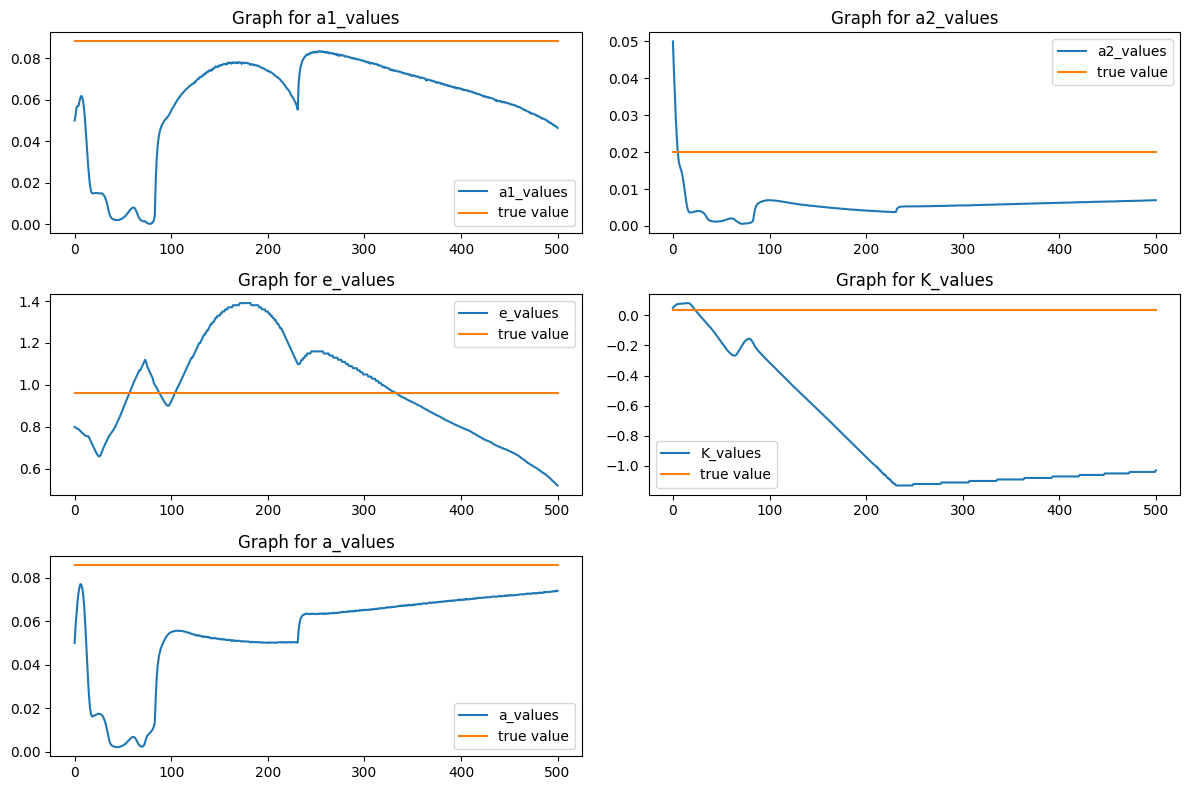

In [28]:
dp_4.plot_convergence()